In [2]:
#Installations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Final
import calendar

import evoml_client as ec
from evoml_client.trial_conf_models import BudgetMode


/home/tintern/miniconda3/envs/analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Connecting to evoml
API_URL: Final[str] = "https://evoml.ai"
EVOML_USERNAME: Final[str] = ""
EVOML_PASSWORD: Final[str] = ""

# Connect to evoML platform
ec.init(base_url=API_URL, username='jquaquah@gmail.com', password='Jqoujaoquah#...03')


True

In [6]:
#Loading and cleaing data
def load_transaction_data(csv_path):
    """Load and prepare transaction data"""
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Find date column
    date_col = next((c for c in df.columns if 'date' in c.lower()), df.columns[0])
    print(f"Using '{date_col}' as date column")
    
    # Try flexible date parsing
    try:
        # First try extracting just the date part if there's a space
        if any(isinstance(x, str) and ' ' in x for x in df[date_col].dropna().tolist()):
            date_parts = df[date_col].astype(str).str.split(' ').str[0]
            df['time'] = pd.to_datetime(date_parts, format='%d/%m/%Y', errors='coerce')
        else:
            # Try with flexible parsing
            df['time'] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    except Exception as e:
        print(f"Date parsing failed: {e}")
        print("Creating artificial dates")
        df['time'] = pd.date_range(start='2023-01-01', periods=len(df))
    
    # Find amount column
    amount_col = next((c for c in df.columns if any(x in c.lower() for x in ['amount', 'value'])), 
                     df.select_dtypes(include=['number']).columns[0])
    print(f"Using '{amount_col}' as amount column")
    
    # Clean data
    df['amount'] = pd.to_numeric(df[amount_col], errors='coerce').abs()
    clean_df = df[['time', 'amount']].dropna()
    
    # Add date components
    clean_df['day_of_week'] = clean_df['time'].dt.dayofweek
    clean_df['month'] = clean_df['time'].dt.month
    clean_df['year'] = clean_df['time'].dt.year
    clean_df['is_weekend'] = clean_df['day_of_week'] >= 5  # 5=Sat, 6=Sun
    
    print(f"Loaded {len(clean_df)} valid transactions")
    return clean_df

In [7]:
#Plotting daily spending
# Your CSV path 
csv_path = "/home/tintern/Desktop/Daily Household Transactions.csv"

# Load the data
df = load_transaction_data(csv_path)

# Create daily aggregation
daily = df.groupby(df['time'].dt.date).agg({
    'amount': ['count', 'sum', 'mean', 'max']
})
daily.columns = ['count', 'total', 'mean', 'max']
daily.index = pd.to_datetime(daily.index)

# Detect anomalies
anomalies = {
    'statistical': [],
    'velocity': [],
    'contextual': []
}

# 1. Statistical outliers (unusual daily totals)
mean_total = daily['total'].mean()
std_total = max(daily['total'].std(), 0.01)

for date, row in daily.iterrows():
    z_score = (row['total'] - mean_total) / std_total
    if abs(z_score) > 2.5:
        anomalies['statistical'].append({
            'date': date,
            'value': row['total'],
            'z_score': z_score
        })

# 2. Velocity anomalies (unusual transaction counts)
mean_count = daily['count'].mean()
std_count = max(daily['count'].std(), 0.01)

for date, row in daily.iterrows():
    z_score = (row['count'] - mean_count) / std_count
    if abs(z_score) > 2.5:
        anomalies['velocity'].append({
            'date': date,
            'count': row['count'],
            'z_score': z_score
        })

# 3. Day-of-week contextual anomalies
dow_stats = df.groupby('day_of_week')['amount'].agg(['mean', 'std', 'count'])

for _, tx in df.iterrows():
    dow = tx['day_of_week']
    if dow_stats.loc[dow, 'count'] >= 5:  # Only check days with enough data
        mean = dow_stats.loc[dow, 'mean']
        std = max(dow_stats.loc[dow, 'std'], 0.01)
        z_score = (tx['amount'] - mean) / std
        
        if abs(z_score) > 3.0:  # Stricter threshold for day-of-week
            anomalies['contextual'].append({
                'time': tx['time'],
                'amount': tx['amount'],
                'day_of_week': dow,
                'z_score': z_score
            })

Using 'Date' as date column
Using 'Amount' as amount column
Loaded 2461 valid transactions



GRAPH 1: Daily Spending with Outliers


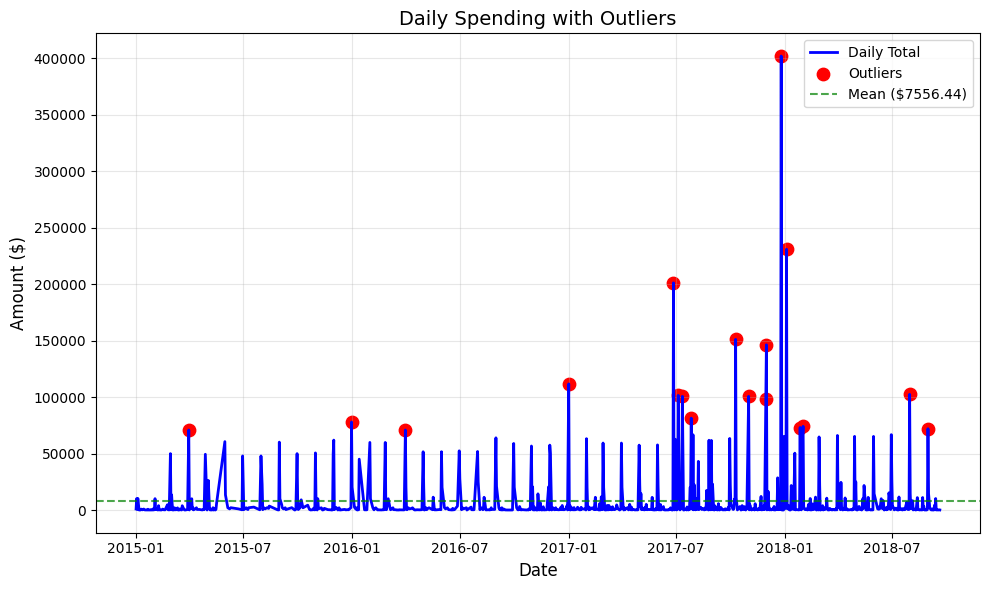

In [8]:
def plot_daily_spending():
    """Plot daily spending with statistical outliers highlighted"""
    plt.figure(figsize=(10, 6))
    
    # Plot main spending line
    plt.plot(daily.index, daily['total'], 'b-', linewidth=2, label='Daily Total')
    
    # Mark outliers
    if anomalies['statistical']:
        outlier_dates = [a['date'] for a in anomalies['statistical']]
        outlier_values = [a['value'] for a in anomalies['statistical']]
        plt.scatter(outlier_dates, outlier_values, color='red', s=80, label='Outliers')
    
    # Add mean line
    mean_total = daily['total'].mean()
    plt.axhline(y=mean_total, color='g', linestyle='--', alpha=0.7, label=f'Mean (${mean_total:.2f})')
    
    plt.title('Daily Spending with Outliers', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Amount ($)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run Graph 1
print("\nGRAPH 1: Daily Spending with Outliers")
plot_daily_spending()

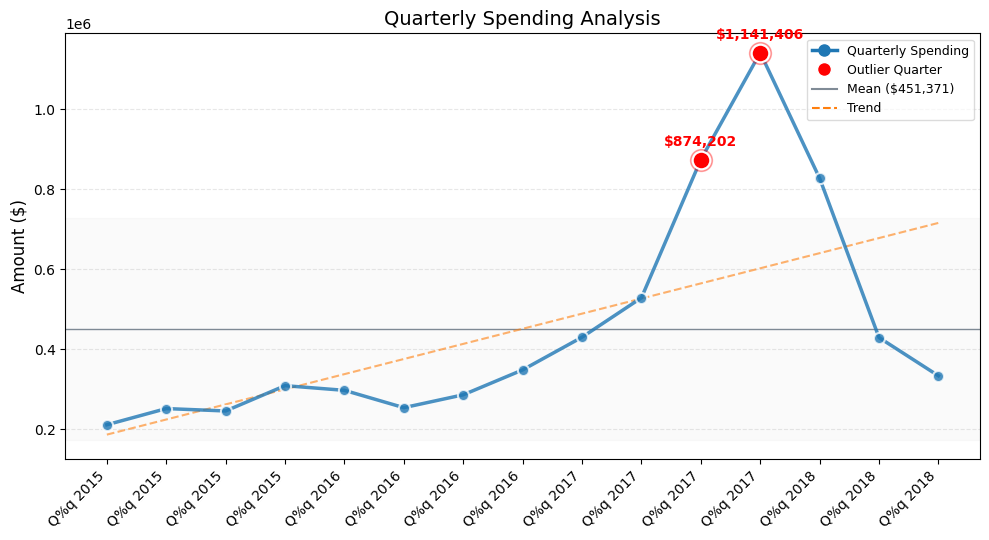

Analysis of 15 quarters found 2 outliers:
• Q%q 2017: $874,202 (above average by 93.7%)
• Q%q 2017: $1,141,406 (above average by 152.9%)


In [9]:
#Plotting quarterly spending
def analyze_quarterly_spending(csv_path):
    """Optimized quarterly spending analysis with fixed deprecation warnings"""
    # 1. Efficient data loading and processing
    df = pd.read_csv(csv_path)
    
    # Find columns with list comprehension
    date_col = next((c for c in df.columns if 'date' in c.lower()), df.columns[0])
    amount_col = next((c for c in df.select_dtypes(include=['number']).columns 
                     if any(x in c.lower() for x in ['amount', 'value', 'price'])), 
                     df.select_dtypes(include=['number']).columns[0])
    
    # Create minimal dataframe with only needed columns
    df = pd.DataFrame({
        'date': pd.to_datetime(df[date_col], dayfirst=True, errors='coerce'),
        'amount': pd.to_numeric(df[amount_col], errors='coerce').abs()
    }).dropna()
    
    # Group by quarter using recommended 'QE' instead of deprecated 'Q'
    quarterly = df.groupby(pd.Grouper(key='date', freq='Q'))['amount'].sum().reset_index()
    quarterly['quarter'] = quarterly['date'].dt.to_period('Q')
    quarterly['label'] = quarterly['date'].dt.strftime('Q%q %Y')
    
    # Validate data
    if len(quarterly) < 2:
        print("Insufficient quarterly data")
        return
    
    # 2. Calculate statistics in one step
    mean, std = quarterly['amount'].mean(), quarterly['amount'].std()
    quarterly['z_score'] = (quarterly['amount'] - mean) / max(std, 0.001)
    quarterly['outlier'] = abs(quarterly['z_score']) > 1.5
    
    # 3. Create visualization efficiently
    fig, ax = plt.subplots(figsize=(10, 5.5), facecolor='white')
    
    # Add reference elements
    ax.axhspan(mean-std, mean+std, alpha=0.1, color='lightgray', zorder=1)
    ax.axhline(y=mean, color='#2c3e50', linestyle='-', linewidth=1, alpha=0.6, zorder=2)
    
    # Plot main line in one call
    ax.plot(range(len(quarterly)), quarterly['amount'], 'o-', color='#1f77b4', 
           linewidth=2.5, markersize=8, alpha=0.8, zorder=3, 
           markerfacecolor='#1f77b4', markeredgecolor='white', markeredgewidth=1.5)
    
    # Add trend line if sufficient data
    if len(quarterly) > 2:
        x = np.arange(len(quarterly))
        z = np.polyfit(x, quarterly['amount'], 1)
        trend_line = np.poly1d(z)(x)
        ax.plot(x, trend_line, color='#ff7f0e', linestyle='--', 
               linewidth=1.5, alpha=0.6, zorder=2)
    
    # Highlight outliers efficiently
    outliers = quarterly[quarterly['outlier']]
    if not outliers.empty:
        outlier_indices = [quarterly.index.get_loc(i) for i in outliers.index]
        outlier_values = outliers['amount'].values
        
        # Plot all outlier points at once
        ax.scatter(outlier_indices, outlier_values, color='red', s=160, zorder=4, 
                 marker='o', edgecolor='white', linewidth=1.5)
        
        # Add glow effect for all outliers at once
        ax.scatter(outlier_indices, outlier_values, color='red', s=250, alpha=0.3, zorder=3)
        
        # Add labels for outliers
        for idx, value in zip(outlier_indices, outlier_values):
            ax.annotate(f"${value:,.0f}", xy=(idx, value), xytext=(0, 10),
                      textcoords="offset points", ha='center', fontsize=10,
                      fontweight='bold', color='red')
    
    # Add non-outlier labels when space permits
    if len(quarterly) <= 12:
        normal_indices = [quarterly.index.get_loc(i) for i in quarterly[~quarterly['outlier']].index]
        normal_values = quarterly.loc[~quarterly['outlier'], 'amount'].values
        
        for idx, value in zip(normal_indices, normal_values):
            ax.annotate(f"${value:,.0f}", xy=(idx, value), xytext=(0, 7),
                      textcoords="offset points", ha='center', fontsize=9,
                      color='#444444')
    
    # Style chart efficiently
    ax.set_title('Quarterly Spending Analysis', fontsize=14)
    ax.set_ylabel('Amount ($)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
    
    # Set x-ticks all at once
    ax.set_xticks(range(len(quarterly)))
    ax.set_xticklabels(quarterly['label'], rotation=45, ha='right')
    
    # Create legend efficiently
    legend_elements = [
        Line2D([0], [0], color='#1f77b4', marker='o', linewidth=2.5, markersize=8, label='Quarterly Spending'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outlier Quarter'),
        Line2D([0], [0], color='#2c3e50', alpha=0.6, label=f'Mean (${mean:,.0f})')
    ]
    
    if len(quarterly) > 2:
        legend_elements.append(Line2D([0], [0], color='#ff7f0e', linestyle='--', label='Trend'))
    
    ax.legend(handles=legend_elements, loc='best', framealpha=0.7, fontsize=9)
    
    # Finalize layout
    plt.tight_layout()
    plt.show()
    
    # 4. Print insights concisely
    if not outliers.empty:
        print(f"Analysis of {len(quarterly)} quarters found {len(outliers)} outliers:")
        for _, row in outliers.iterrows():
            diff_pct = (row['amount'] / mean - 1) * 100
            direction = "above" if diff_pct > 0 else "below"
            print(f"• {row['label']}: ${row['amount']:,.0f} ({direction} average by {abs(diff_pct):.1f}%)")

# Run analysis
analyze_quarterly_spending(csv_path)


GRAPH 3: Anomaly Counts by Type


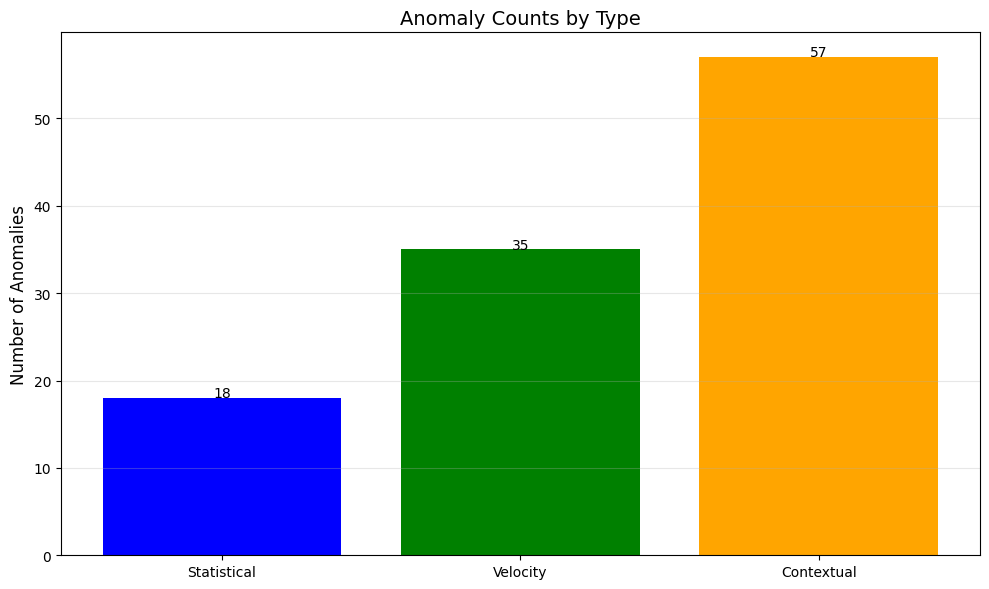

In [10]:
#Plotting anoimaly counts by type
def plot_anomaly_counts():
    """Plot bar chart of anomaly counts by type"""
    counts = {k: len(v) for k, v in anomalies.items()}
    if not any(counts.values()):
        print("No anomalies to plot")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Create bar chart
    labels = ['Statistical', 'Velocity', 'Contextual']
    values = [counts.get('statistical', 0), counts.get('velocity', 0), counts.get('contextual', 0)]
    colors = ['blue', 'green', 'orange']
    
    plt.bar(labels, values, color=colors)
    
    # Add value labels on top of bars
    for i, v in enumerate(values):
        plt.text(i, v + 0.1, str(v), ha='center')
    
    plt.title('Anomaly Counts by Type', fontsize=14)
    plt.ylabel('Number of Anomalies', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run Graph 3
print("\nGRAPH 3: Anomaly Counts by Type")
plot_anomaly_counts()


NEW GRAPH 4: Spending by Day of Week


<Figure size 1200x600 with 0 Axes>

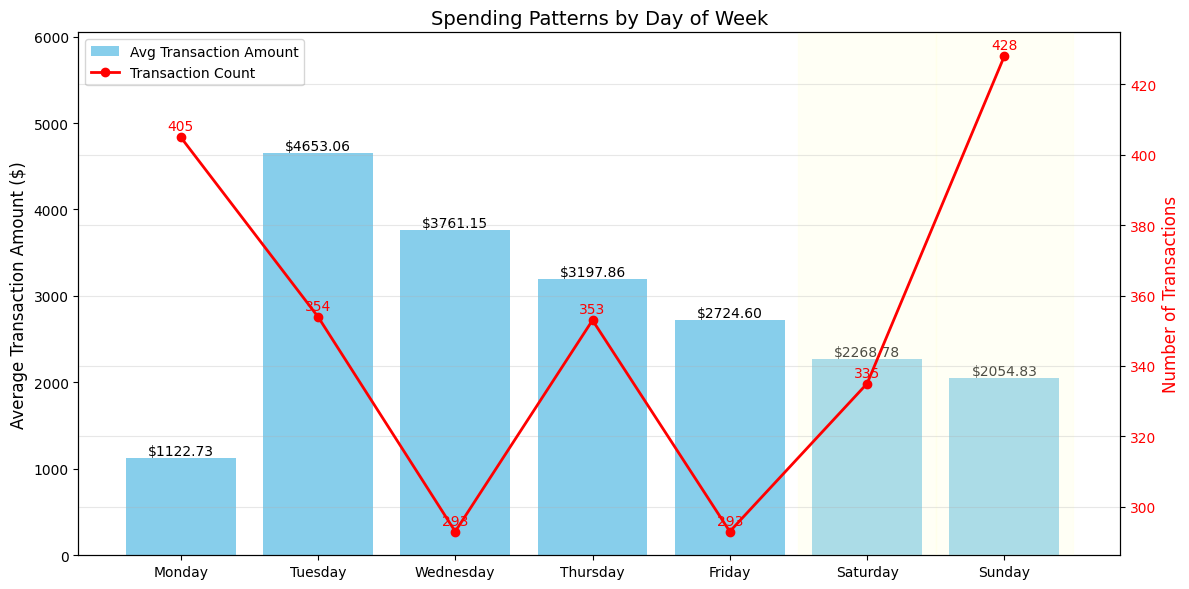

In [11]:
#Plotting spending patterns by day of week
def plot_day_of_week_pattern():
    """Plot spending patterns by day of week"""
    plt.figure(figsize=(12, 6))
    
    # Get spending by day of week
    dow_spending = df.groupby('day_of_week')['amount'].agg(['sum', 'count', 'mean'])
    
    # Sort by day of week
    dow_spending = dow_spending.reindex(range(7))
    
    # Create day names
    day_names = [calendar.day_name[i] for i in range(7)]  # 0=Monday, 6=Sunday
    
    # Create bar chart with dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot mean amount bars
    bars = ax1.bar(day_names, dow_spending['mean'], color='skyblue', label='Avg Transaction Amount')
    ax1.set_ylabel('Average Transaction Amount ($)', fontsize=12)
    ax1.set_ylim(0, dow_spending['mean'].max() * 1.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'${height:.2f}', ha='center', va='bottom', fontsize=10)
    
    # Create second y-axis for transaction count
    ax2 = ax1.twinx()
    ax2.plot(day_names, dow_spending['count'], 'ro-', linewidth=2, label='Transaction Count')
    ax2.set_ylabel('Number of Transactions', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add value labels for line
    for i, count in enumerate(dow_spending['count']):
        ax2.annotate(str(count), (i, count), xytext=(0, 5), 
                    textcoords='offset points', ha='center', fontsize=10, color='red')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Highlight weekends
    for i in [5, 6]:  # 5=Saturday, 6=Sunday
        plt.axvspan(i-0.5, i+0.5, color='lightyellow', alpha=0.3)
    
    plt.title('Spending Patterns by Day of Week', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run New Graph 4
print("\nNEW GRAPH 4: Spending by Day of Week")
plot_day_of_week_pattern()


GRAPH 6: Transaction Distribution


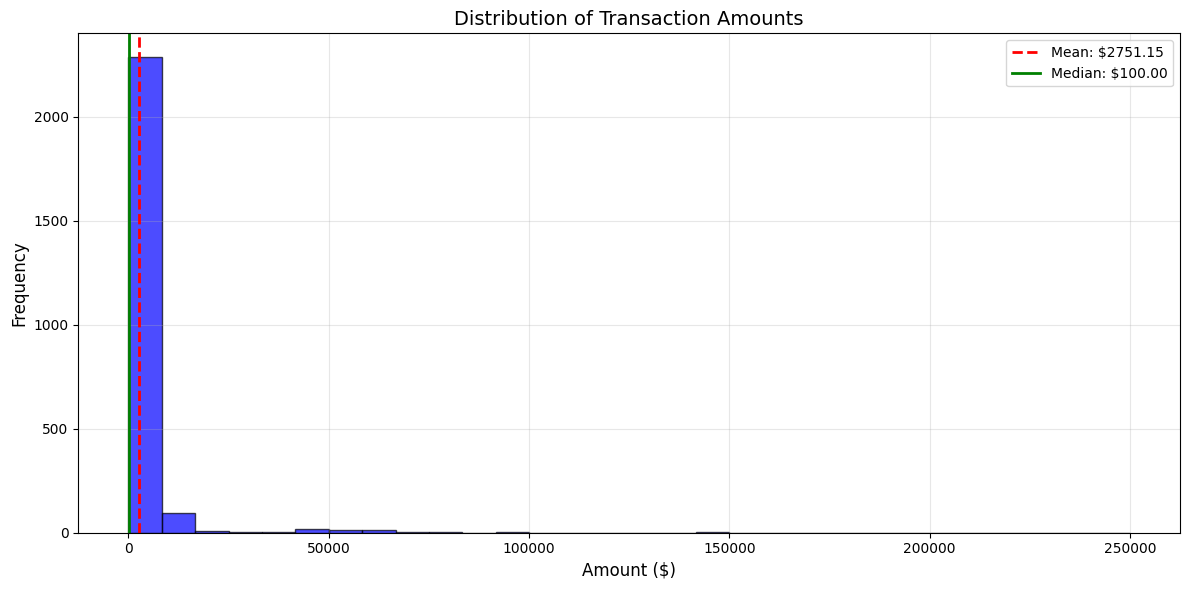

In [12]:
#Plotting transaction distribution
def plot_transaction_distribution():
    """Plot distribution of transaction amounts"""
    plt.figure(figsize=(12, 6))
    
    # Create histogram of transaction amounts
    plt.hist(df['amount'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    
    # Add vertical line for mean and median
    mean_amount = df['amount'].mean()
    median_amount = df['amount'].median()
    
    plt.axvline(x=mean_amount, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_amount:.2f}')
    plt.axvline(x=median_amount, color='green', linestyle='-', linewidth=2, label=f'Median: ${median_amount:.2f}')
    
    plt.title('Distribution of Transaction Amounts', fontsize=14)
    plt.xlabel('Amount ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run Bonus Graph 6
print("\nGRAPH 6: Transaction Distribution")
plot_transaction_distribution()


In [14]:
#uploading data to evoml
data = pd.read_csv('/home/tintern/Desktop/Daily Household Transactions.csv')
dataset = ec.Dataset.from_pandas(data, name="Daily Household Transactions")
dataset.put()
dataset.wait()

print(f"Dataset URL: {API_URL}/platform/datasets/view/{dataset.dataset_id}")

KeyboardInterrupt: 

In [16]:
# First, define your target column
target_column = "Amount" 

config = ec.TrialConfig.with_default(
    task=ec.MlTask.classification,
    budget_mode=BudgetMode.fast,
    loss_funcs=["ROC AUC"],
    dataset_id=dataset.dataset_id,
)

# Trying disabling hyperparameter tuning for faster trial execution
# config.enableBudgetTuning = False

trial, _ = ec.Trial.from_dataset_id(
    dataset.dataset_id,
    target_col=target_column,
    trial_name="Fraud Detection",
    config=config,
)

trial.run(timeout=900)

100%|██████████| 51/51 [00:00<00:00, 70341.83kb/s]


Couldnt match any status: ,status ispending


KeyboardInterrupt: 

In [ ]:
metrics = trial.get_metrics_dataframe()
selected_metrics = metrics.loc[:, pd.IndexSlice["classification-roc", ["validation", "test"]]]
print(selected_metrics.sort_values(by=("classification-roc", "validation"), ascending=False).iloc[:5])

NameError: name 'trial' is not defined

In [15]:
best_model = trial.get_best()
best_model.build_model()

NameError: name 'trial' is not defined

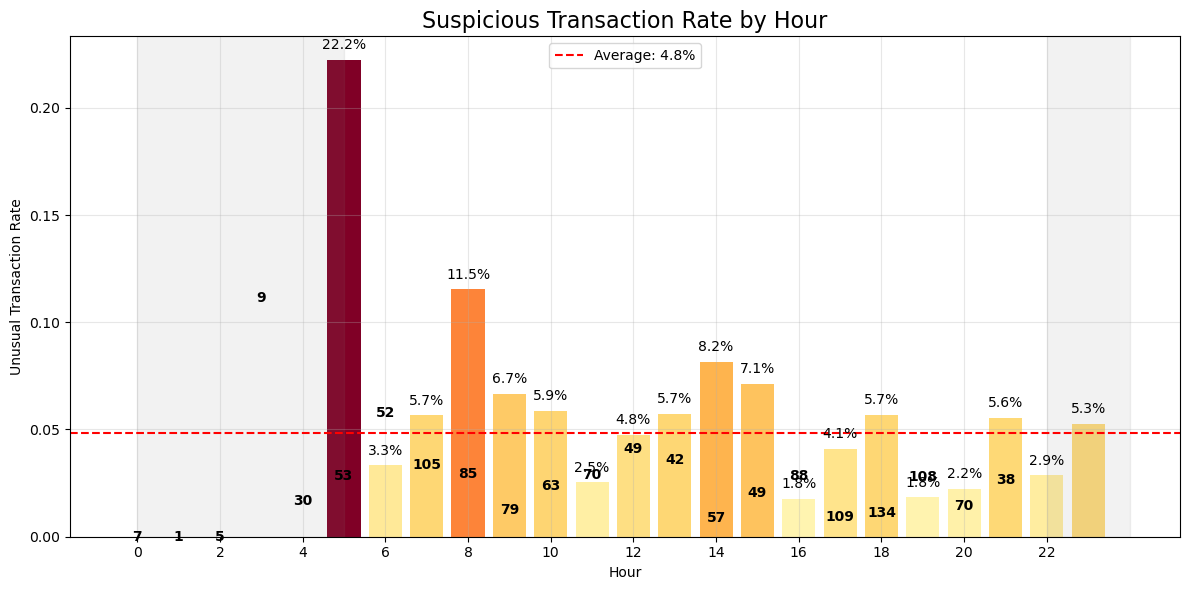

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_hourly_patterns(csv_path):
    """Analyze suspicious transaction patterns by hour - optimized version"""
    # 1. Load essential data only
    df = pd.read_csv(csv_path)
    
    # Find key columns efficiently with list comprehension
    date_col = next((c for c in df.columns if 'date' in c.lower()), df.columns[0])
    num_cols = df.select_dtypes(include=['number']).columns
    amount_col = next((c for c in num_cols if any(x in c.lower() for x in ['amount', 'value'])), num_cols[0])
    
    # Extract only needed data (hour and amount)
    df = pd.DataFrame({
        'hour': pd.to_datetime(df[date_col], dayfirst=True, errors='coerce').dt.hour,
        'amount': pd.to_numeric(df[amount_col], errors='coerce').abs()
    }).dropna()
    
    # 2. Calculate anomalies in one step
    # Pre-compute stats for vectorized operations
    hour_means = df.groupby('hour')['amount'].transform('mean')
    hour_stds = df.groupby('hour')['amount'].transform('std')
    overall_std = df['amount'].std()
    
    # Replace zero stds and calculate z-scores
    hour_stds = hour_stds.replace(0, overall_std)
    amount_zscore = (df['amount'] - hour_means) / hour_stds
    
    # Flag unusual transactions (z-score > 2 or top 5%)
    q95 = df['amount'].quantile(0.95)
    df['unusual'] = ((amount_zscore > 2) | (df['amount'] > q95)).astype(int)
    
    # 3. Calculate unusual rates directly
    result = df.groupby('hour').agg(
        count=('amount', 'size'),
        unusual=('unusual', 'sum')
    )
    result['rate'] = result['unusual'] / result['count']
    
    # 4. Create visualization (optimized)
    plt.figure(figsize=(12, 6))
    
    # Set up color gradient based on unusual rates
    max_rate = result['rate'].max() or 1  # Avoid div by zero
    colors = plt.cm.YlOrRd(result['rate'] / max_rate)
    
    # Create all bars at once
    bars = plt.bar(result.index, result['rate'], color=colors)
    
    # Add count labels in one step using list comprehension
    for i, count in enumerate(result['count']):
        plt.text(i, result['rate'].iloc[i]/2, str(int(count)), 
                ha='center', va='center', fontweight='bold')
    
    # Add percentage labels efficiently
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.1%}', ha='center')
    
    # Add reference line and styling
    avg_rate = df['unusual'].mean()
    plt.axhline(y=avg_rate, color='red', linestyle='--', 
               label=f'Average: {avg_rate:.1%}')
    
    # Night hours shading (consolidated)
    for span in [(0, 5), (22, 24)]:
        plt.axvspan(*span, alpha=0.1, color='gray')
    
    # Style chart
    plt.title('Suspicious Transaction Rate by Hour', fontsize=16)
    plt.xlabel('Hour')
    plt.ylabel('Unusual Transaction Rate')
    plt.xticks(range(0, 24, 2))
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return result

# Run analysis
csv_path = r"C:\Users\Jojo\OneDrive - The University of Nottingham\Documents\Economics and Finance Soc\TurinTechai internship\Daily Household Transactions.csv"
hourly_data = analyze_hourly_patterns(csv_path)

ModuleNotFoundError: No module named 'seaborn'